# ANÁLISIS PROFUNDO: Eventos E0 (2004-2025)

**Objetivo**: Análisis exhaustivo de eventos info-rich E0

**Preguntas clave**:
1. ¿Cuántos eventos E0 tiene cada ticker?
2. ¿Qué combinaciones de filtros se cumplen más? (4 filtros, 3, 2, 1)
3. ¿Cuándo se cumplen los 4 filtros a la vez? (fecha/hora exacta)
4. ¿Cuál es la mejor hora del día para eventos E0?
5. ¿Cuál es el mejor día del mes?
6. ¿Cuál es el mejor mes del año?
7. ¿Cuál fue el mejor año?

**Filtros E0 evaluados**:
- **F1**: RVOL ≥ 2.0 (volumen relativo)
- **F2**: |%chg| ≥ 15% (cambio precio)
- **F3**: $vol ≥ $5M (dollar volume)
- **F4**: Precio $0.20-$20 (rango small caps)

**Salidas**:
- CSV para TradingView verification
- Gráficos comprehensivos
- Tablas de ranking

---

In [1]:
import polars as pl
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Config
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['font.size'] = 11

# Paths
PROJECT_ROOT = Path(r"D:\04_TRADING_SMALLCAPS")
WATCHLISTS = PROJECT_ROOT / "processed" / "universe" / "info_rich" / "daily"
TRADES_DIR = PROJECT_ROOT / "raw" / "polygon" / "trades"
OUTPUT_DIR = PROJECT_ROOT / "01_DayBook" / "fase_01" / "C_v2_ingesta_tiks_2004_2025" / "notebooks"

print("✅ Setup complete")
print(f"📂 Watchlists: {WATCHLISTS}")
print(f"📂 Trades: {TRADES_DIR}")
print(f"📂 Output: {OUTPUT_DIR}")

✅ Setup complete
📂 Watchlists: D:\04_TRADING_SMALLCAPS\processed\universe\info_rich\daily
📂 Trades: D:\04_TRADING_SMALLCAPS\raw\polygon\trades
📂 Output: D:\04_TRADING_SMALLCAPS\01_DayBook\fase_01\C_v2_ingesta_tiks_2004_2025\notebooks


---

## 1. CARGA DE DATOS: Watchlists E0 Completas

In [2]:
print("="*80)
print("CARGANDO WATCHLISTS E0 COMPLETAS")
print("="*80)

# Cargar TODAS las watchlists (lazy scan)
print("\n📊 Cargando todos los registros...")
df_all = pl.scan_parquet(WATCHLISTS / "date=*" / "watchlist.parquet").collect()

print(f"✅ Total registros cargados: {len(df_all):,}")
print(f"   Columnas: {df_all.columns}")
print(f"   Memoria: {df_all.estimated_size('mb'):.2f} MB")

# Filtrar SOLO eventos E0 (info_rich=True)
df_e0 = df_all.filter(pl.col('info_rich') == True)

print(f"\n✅ Eventos E0 (info_rich=True): {len(df_e0):,}")
print(f"   Tickers únicos: {df_e0['ticker'].n_unique():,}")
print(f"   Días únicos: {df_e0['trading_day'].n_unique():,}")
print(f"   Rango temporal: {df_e0['trading_day'].min()} → {df_e0['trading_day'].max()}")

# Mostrar sample
print(f"\n📋 Sample (primeras 5 filas):")
print(df_e0.head(5).select(['ticker', 'trading_day', 'rvol30', 'pctchg_d', 'dollar_vol_d', 'close_d']))

CARGANDO WATCHLISTS E0 COMPLETAS

📊 Cargando todos los registros...
✅ Total registros cargados: 8,696,865
   Columnas: ['ticker', 'trading_day', 'close_d', 'pctchg_d', 'rvol30', 'vol_d', 'dollar_vol_d', 'vwap_d', 'market_cap_d', 'r_rvol', 'r_chg', 'r_dvol', 'r_px', 'info_rich']
   Memoria: 467.23 MB

✅ Eventos E0 (info_rich=True): 29,555
   Tickers únicos: 4,898
   Días únicos: 4,949
   Rango temporal: 2004-01-06 → 2025-10-21

📋 Sample (primeras 5 filas):
shape: (5, 6)
┌────────┬─────────────┬──────────┬───────────┬──────────────┬─────────┐
│ ticker ┆ trading_day ┆ rvol30   ┆ pctchg_d  ┆ dollar_vol_d ┆ close_d │
│ ---    ┆ ---         ┆ ---      ┆ ---       ┆ ---          ┆ ---     │
│ str    ┆ date        ┆ f64      ┆ f64       ┆ f64          ┆ f64     │
╞════════╪═════════════╪══════════╪═══════════╪══════════════╪═════════╡
│ WRLS   ┆ 2004-01-06  ┆ 2.662754 ┆ 0.234586  ┆ 5.2358e6     ┆ 8.21    │
│ STAA   ┆ 2004-01-06  ┆ 2.706896 ┆ -0.179464 ┆ 2.3659e7     ┆ 9.19    │
│ ARRS   ┆ 2004

---

## 2. EVALUACIÓN DE FILTROS INDIVIDUALES

**Pregunta**: ¿Qué % de eventos E0 cumplen cada filtro?

**Thresholds**:
- F1: RVOL ≥ 2.0
- F2: |%chg| ≥ 15%
- F3: $vol ≥ $5M
- F4: Precio $0.20-$20

EVALUACIÓN FILTROS INDIVIDUALES

Total eventos E0: 29,555

Filtro                         Cumple          %         
-------------------------------------------------------
F1: RVOL ≥ 2.0                         29,555     100.0%
F2: |%chg| ≥ 15%                       29,555     100.0%
F3: $vol ≥ $5M                         29,555     100.0%
F4: Precio $0.20-$20                   29,555     100.0%


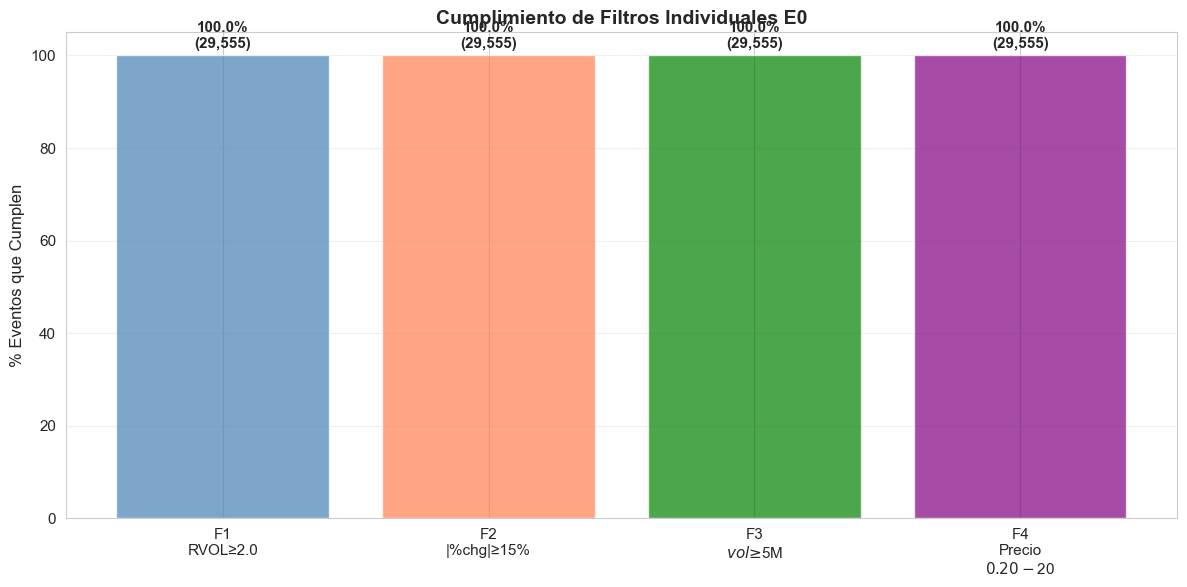


✅ Gráfico guardado: e0_filtros_individuales.png


In [3]:
print("="*80)
print("EVALUACIÓN FILTROS INDIVIDUALES")
print("="*80)

# Evaluar cada filtro
df_e0 = df_e0.with_columns([
    (pl.col('rvol30') >= 2.0).alias('f1_rvol'),
    (pl.col('pctchg_d').abs() >= 0.15).alias('f2_pctchg'),
    (pl.col('dollar_vol_d') >= 5_000_000).alias('f3_dvol'),
    ((pl.col('close_d') >= 0.20) & (pl.col('close_d') <= 20.0)).alias('f4_price')
])

# Contar cumplimiento
total = len(df_e0)
f1_count = df_e0['f1_rvol'].sum()
f2_count = df_e0['f2_pctchg'].sum()
f3_count = df_e0['f3_dvol'].sum()
f4_count = df_e0['f4_price'].sum()

print(f"\nTotal eventos E0: {total:,}")
print(f"\n{'Filtro':<30} {'Cumple':<15} {'%':<10}")
print("-"*55)
print(f"{'F1: RVOL ≥ 2.0':<30} {f1_count:>14,} {f1_count/total*100:>9.1f}%")
print(f"{'F2: |%chg| ≥ 15%':<30} {f2_count:>14,} {f2_count/total*100:>9.1f}%")
print(f"{'F3: $vol ≥ $5M':<30} {f3_count:>14,} {f3_count/total*100:>9.1f}%")
print(f"{'F4: Precio $0.20-$20':<30} {f4_count:>14,} {f4_count/total*100:>9.1f}%")

# Gráfico
fig, ax = plt.subplots(figsize=(12, 6))
filtros = ['F1\nRVOL≥2.0', 'F2\n|%chg|≥15%', 'F3\n$vol≥$5M', 'F4\nPrecio\n$0.20-$20']
counts = [f1_count, f2_count, f3_count, f4_count]
percentages = [c/total*100 for c in counts]

bars = ax.bar(filtros, percentages, color=['steelblue', 'coral', 'green', 'purple'], alpha=0.7)
ax.set_ylabel('% Eventos que Cumplen', fontsize=12)
ax.set_title('Cumplimiento de Filtros Individuales E0', fontsize=14, fontweight='bold')
ax.set_ylim(0, 105)
ax.grid(axis='y', alpha=0.3)

# Añadir valores
for bar, pct, cnt in zip(bars, percentages, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{pct:.1f}%\n({cnt:,})',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'e0_filtros_individuales.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Gráfico guardado: e0_filtros_individuales.png")

---

## 3. COMBINACIONES DE FILTROS

**Pregunta**: ¿Cuántos eventos cumplen 4, 3, 2, 1 filtros?

**Combinaciones posibles**:
- 4 filtros: Evento "perfecto"
- 3 filtros: 4 combinaciones (faltan F1, F2, F3, o F4)
- 2 filtros: 6 combinaciones
- 1 filtro: 4 combinaciones

COMBINACIONES DE FILTROS

# Filtros       Eventos         %         
----------------------------------------
4                       29,555     100.0%


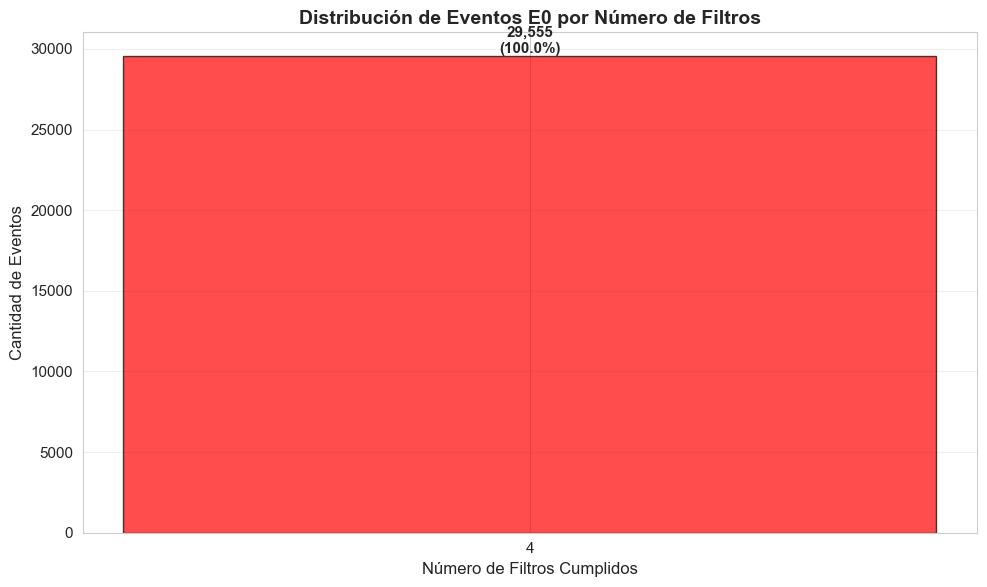


✅ Gráfico guardado: e0_distribucion_filtros.png


In [4]:
print("="*80)
print("COMBINACIONES DE FILTROS")
print("="*80)

# Contar cuántos filtros cumple cada evento
df_e0 = df_e0.with_columns(
    (pl.col('f1_rvol').cast(pl.Int32) + 
     pl.col('f2_pctchg').cast(pl.Int32) + 
     pl.col('f3_dvol').cast(pl.Int32) + 
     pl.col('f4_price').cast(pl.Int32)).alias('num_filtros')
)

# Distribución
dist_filtros = df_e0.group_by('num_filtros').agg(pl.count().alias('count')).sort('num_filtros', descending=True)

print(f"\n{'# Filtros':<15} {'Eventos':<15} {'%':<10}")
print("-"*40)
for row in dist_filtros.iter_rows(named=True):
    num = row['num_filtros']
    cnt = row['count']
    pct = cnt/total*100
    print(f"{num:<15} {cnt:>14,} {pct:>9.1f}%")

# Gráfico
fig, ax = plt.subplots(figsize=(10, 6))
dist_pd = dist_filtros.to_pandas().sort_values('num_filtros')

colors = ['red', 'orange', 'yellow', 'lightgreen', 'darkgreen']
bars = ax.bar(dist_pd['num_filtros'].astype(str), dist_pd['count'], 
              color=colors[:len(dist_pd)], alpha=0.7, edgecolor='black')

ax.set_xlabel('Número de Filtros Cumplidos', fontsize=12)
ax.set_ylabel('Cantidad de Eventos', fontsize=12)
ax.set_title('Distribución de Eventos E0 por Número de Filtros', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Añadir valores
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}\n({height/total*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'e0_distribucion_filtros.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Gráfico guardado: e0_distribucion_filtros.png")

---

## 4. EVENTOS CON 4 FILTROS ("Eventos Perfectos")

**Pregunta**: ¿Cuándo y dónde se cumplen los 4 filtros a la vez?

**Output**: CSV con ticker + fecha/hora para verificar en TradingView

EVENTOS PERFECTOS (4 FILTROS)

✅ Eventos con 4 filtros: 29,555
   Tickers únicos: 4,898
   % del total E0: 100.00%

📊 TOP 20 Tickers con Más Eventos Perfectos:
shape: (20, 2)
┌────────┬───────────────────┐
│ ticker ┆ eventos_perfectos │
│ ---    ┆ ---               │
│ str    ┆ u32               │
╞════════╪═══════════════════╡
│ BCRX   ┆ 63                │
│ GERN   ┆ 53                │
│ VXRT   ┆ 51                │
│ SRNE   ┆ 50                │
│ BLDP   ┆ 43                │
│ …      ┆ …                 │
│ YRCW   ┆ 38                │
│ VERI   ┆ 37                │
│ IMGN   ┆ 36                │
│ KERX   ┆ 36                │
│ ATOS   ┆ 36                │
└────────┴───────────────────┘


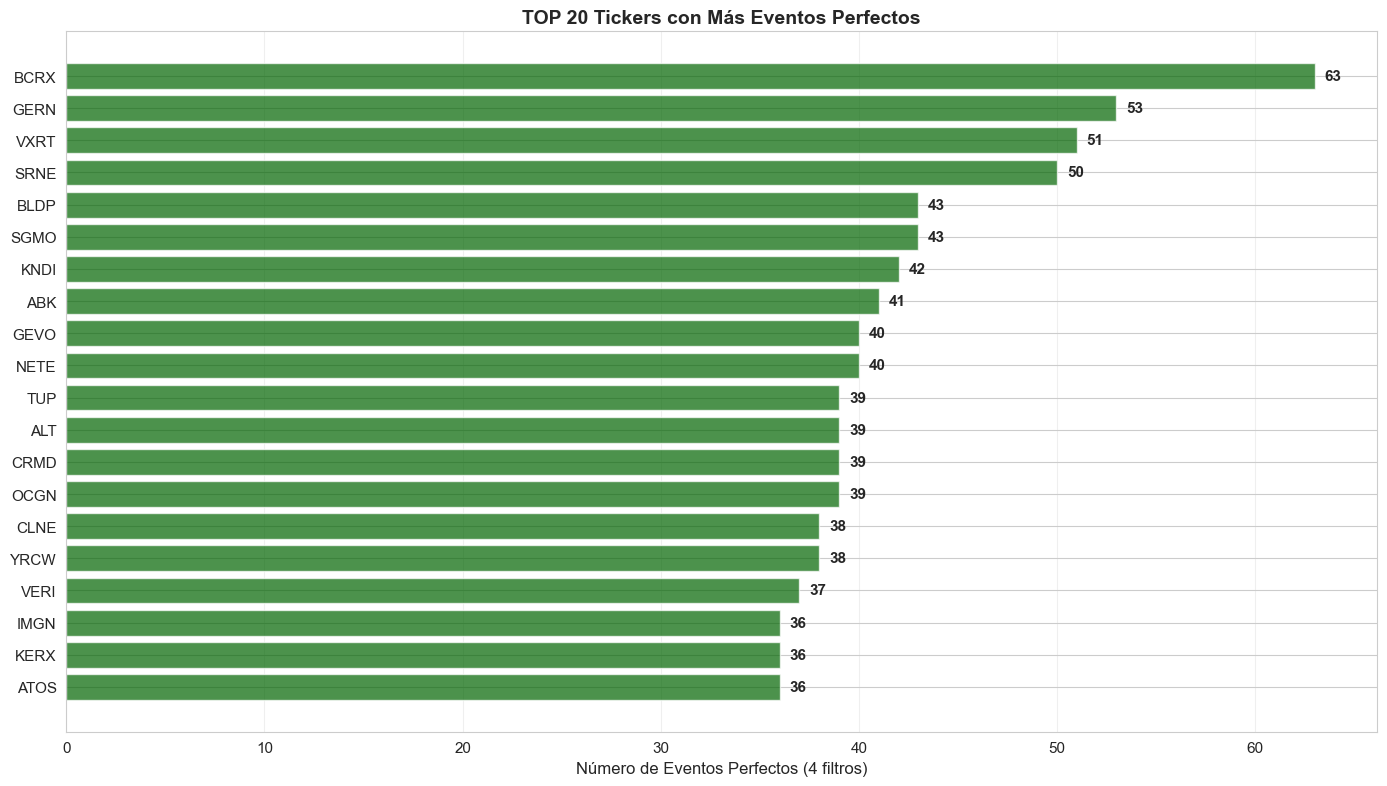


✅ Gráfico guardado: e0_top20_perfect.png


In [5]:
print("="*80)
print("EVENTOS PERFECTOS (4 FILTROS)")
print("="*80)

# Filtrar eventos con 4 filtros
df_perfect = df_e0.filter(pl.col('num_filtros') == 4)

print(f"\n✅ Eventos con 4 filtros: {len(df_perfect):,}")
print(f"   Tickers únicos: {df_perfect['ticker'].n_unique():,}")
print(f"   % del total E0: {len(df_perfect)/total*100:.2f}%")

# Top 20 tickers con más eventos perfectos
top_perfect = (df_perfect.group_by('ticker')
               .agg(pl.count().alias('eventos_perfectos'))
               .sort('eventos_perfectos', descending=True)
               .head(20))

print(f"\n📊 TOP 20 Tickers con Más Eventos Perfectos:")
print(top_perfect)

# Gráfico
fig, ax = plt.subplots(figsize=(14, 8))
top_pd = top_perfect.to_pandas()

ax.barh(range(len(top_pd)), top_pd['eventos_perfectos'], color='darkgreen', alpha=0.7)
ax.set_yticks(range(len(top_pd)))
ax.set_yticklabels(top_pd['ticker'])
ax.set_xlabel('Número de Eventos Perfectos (4 filtros)', fontsize=12)
ax.set_title('TOP 20 Tickers con Más Eventos Perfectos', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Añadir valores
for i, (ticker, count) in enumerate(zip(top_pd['ticker'], top_pd['eventos_perfectos'])):
    ax.text(count + 0.5, i, f'{count}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'e0_top20_perfect.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Gráfico guardado: e0_top20_perfect.png")

### 4.1 Exportar CSV para TradingView

**Formato**: ticker, date, rvol30, pctchg_d, dollar_vol_d, close_d

In [6]:
print("="*80)
print("EXPORTANDO CSV PARA TRADINGVIEW")
print("="*80)

# Seleccionar columnas relevantes
df_export = df_perfect.select([
    'ticker',
    'trading_day',
    'rvol30',
    'pctchg_d',
    'dollar_vol_d',
    'close_d',
    'vol_d',
    'vwap_d'
]).sort(['trading_day', 'ticker'])

# Exportar
csv_file = OUTPUT_DIR / 'eventos_perfectos_4_filtros_TRADINGVIEW.csv'
df_export.write_csv(csv_file)

print(f"\n✅ CSV exportado: {csv_file.name}")
print(f"   Total filas: {len(df_export):,}")
print(f"\n📋 Sample (primeras 10 filas):")
print(df_export.head(10))

print(f"\n💡 USO EN TRADINGVIEW:")
print(f"   1. Abrir TradingView")
print(f"   2. Buscar ticker en la fecha indicada")
print(f"   3. Verificar: RVOL≥2.0, |%chg|≥15%, $vol≥$5M, precio $0.20-$20")

EXPORTANDO CSV PARA TRADINGVIEW

✅ CSV exportado: eventos_perfectos_4_filtros_TRADINGVIEW.csv
   Total filas: 29,555

📋 Sample (primeras 10 filas):
shape: (10, 8)
┌────────┬─────────────┬──────────┬───────────┬──────────────┬─────────┬─────────────┬───────────┐
│ ticker ┆ trading_day ┆ rvol30   ┆ pctchg_d  ┆ dollar_vol_d ┆ close_d ┆ vol_d       ┆ vwap_d    │
│ ---    ┆ ---         ┆ ---      ┆ ---       ┆ ---          ┆ ---     ┆ ---         ┆ ---       │
│ str    ┆ date        ┆ f64      ┆ f64       ┆ f64          ┆ f64     ┆ f64         ┆ f64       │
╞════════╪═════════════╪══════════╪═══════════╪══════════════╪═════════╪═════════════╪═══════════╡
│ ARRS   ┆ 2004-01-06  ┆ 2.690825 ┆ 0.204348  ┆ 2.0075e8     ┆ 9.141   ┆ 2.3343063e7 ┆ 8.599781  │
│ STAA   ┆ 2004-01-06  ┆ 2.706896 ┆ -0.179464 ┆ 2.3659e7     ┆ 9.19    ┆ 2.495043e6  ┆ 9.482368  │
│ WRLS   ┆ 2004-01-06  ┆ 2.662754 ┆ 0.234586  ┆ 5.2358e6     ┆ 8.21    ┆ 656463.0    ┆ 7.975836  │
│ BBA    ┆ 2004-01-08  ┆ 2.708223 ┆ -0.164122

---

## 5. ANÁLISIS TEMPORAL: ¿Cuándo ocurren los eventos E0?

### 5.1 Distribución por Año

In [7]:
print("="*80)
print("ANÁLISIS TEMPORAL: DISTRIBUCIÓN POR AÑO")
print("="*80)

# Extraer año
df_e0 = df_e0.with_columns(
    pl.col('trading_day').str.slice(0, 4).alias('year')
)

# Eventos E0 por año
by_year = (df_e0.group_by('year')
           .agg(pl.count().alias('eventos'))
           .sort('year'))

print(f"\n{'Año':<10} {'Eventos E0':<15} {'% del Total':<15}")
print("-"*40)
for row in by_year.iter_rows(named=True):
    year = row['year']
    cnt = row['eventos']
    pct = cnt/total*100
    print(f"{year:<10} {cnt:>14,} {pct:>14.2f}%")

# Eventos PERFECTOS (4 filtros) por año
df_perfect = df_perfect.with_columns(
    pl.col('trading_day').str.slice(0, 4).alias('year')
)

perfect_by_year = (df_perfect.group_by('year')
                   .agg(pl.count().alias('eventos_perfectos'))
                   .sort('year'))

# Merge
by_year = by_year.join(perfect_by_year, on='year', how='left').fill_null(0)

# Gráfico
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
by_year_pd = by_year.to_pandas()

# Subplot 1: Todos los eventos E0
ax1.bar(by_year_pd['year'], by_year_pd['eventos'], color='steelblue', alpha=0.7)
ax1.set_ylabel('Número de Eventos E0', fontsize=12)
ax1.set_title('Distribución de Eventos E0 por Año (2004-2025)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Subplot 2: Eventos perfectos
ax2.bar(by_year_pd['year'], by_year_pd['eventos_perfectos'], color='darkgreen', alpha=0.7)
ax2.set_xlabel('Año', fontsize=12)
ax2.set_ylabel('Eventos Perfectos (4 filtros)', fontsize=12)
ax2.set_title('Distribución de Eventos Perfectos por Año', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'e0_distribucion_anual.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Gráfico guardado: e0_distribucion_anual.png")

# Mejor año
best_year = by_year_pd.loc[by_year_pd['eventos'].idxmax()]
print(f"\n🏆 MEJOR AÑO: {best_year['year']} con {best_year['eventos']:,} eventos E0")

ANÁLISIS TEMPORAL: DISTRIBUCIÓN POR AÑO


SchemaError: invalid series dtype: expected `String`, got `date` for series with name `trading_day`

### 5.2 Distribución por Mes del Año

In [8]:
print("="*80)
print("ANÁLISIS TEMPORAL: DISTRIBUCIÓN POR MES")
print("="*80)

# Extraer mes
df_e0 = df_e0.with_columns(
    pl.col('trading_day').str.slice(5, 2).alias('month')
)

# Eventos por mes
by_month = (df_e0.group_by('month')
            .agg(pl.count().alias('eventos'))
            .sort('month'))

print(f"\n{'Mes':<10} {'Eventos E0':<15} {'% del Total':<15}")
print("-"*40)
month_names = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
               'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
for row in by_month.iter_rows(named=True):
    month_num = int(row['month'])
    month_name = month_names[month_num - 1]
    cnt = row['eventos']
    pct = cnt/total*100
    print(f"{month_name:<10} {cnt:>14,} {pct:>14.2f}%")

# Gráfico
fig, ax = plt.subplots(figsize=(14, 6))
by_month_pd = by_month.to_pandas()
by_month_pd['month_name'] = by_month_pd['month'].apply(lambda x: month_names[int(x)-1])

ax.bar(by_month_pd['month_name'], by_month_pd['eventos'], color='coral', alpha=0.7)
ax.set_xlabel('Mes del Año', fontsize=12)
ax.set_ylabel('Número de Eventos E0', fontsize=12)
ax.set_title('Distribución de Eventos E0 por Mes del Año', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Añadir valores
for i, (month, count) in enumerate(zip(by_month_pd['month_name'], by_month_pd['eventos'])):
    ax.text(i, count + 50, f'{count:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'e0_distribucion_mensual.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Gráfico guardado: e0_distribucion_mensual.png")

# Mejor mes
best_month = by_month_pd.loc[by_month_pd['eventos'].idxmax()]
print(f"\n🏆 MEJOR MES: {best_month['month_name']} con {best_month['eventos']:,} eventos E0")

ANÁLISIS TEMPORAL: DISTRIBUCIÓN POR MES


SchemaError: invalid series dtype: expected `String`, got `date` for series with name `trading_day`

### 5.3 Distribución por Día del Mes

In [9]:
print("="*80)
print("ANÁLISIS TEMPORAL: DISTRIBUCIÓN POR DÍA DEL MES")
print("="*80)

# Extraer día
df_e0 = df_e0.with_columns(
    pl.col('trading_day').str.slice(8, 2).alias('day')
)

# Eventos por día
by_day = (df_e0.group_by('day')
          .agg(pl.count().alias('eventos'))
          .sort('day'))

# Gráfico
fig, ax = plt.subplots(figsize=(16, 6))
by_day_pd = by_day.to_pandas()

ax.bar(by_day_pd['day'], by_day_pd['eventos'], color='purple', alpha=0.7)
ax.set_xlabel('Día del Mes', fontsize=12)
ax.set_ylabel('Número de Eventos E0', fontsize=12)
ax.set_title('Distribución de Eventos E0 por Día del Mes', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'e0_distribucion_dia_mes.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Gráfico guardado: e0_distribucion_dia_mes.png")

# Mejor día
best_day = by_day_pd.loc[by_day_pd['eventos'].idxmax()]
print(f"\n🏆 MEJOR DÍA DEL MES: Día {best_day['day']} con {best_day['eventos']:,} eventos E0")

ANÁLISIS TEMPORAL: DISTRIBUCIÓN POR DÍA DEL MES


SchemaError: invalid series dtype: expected `String`, got `date` for series with name `trading_day`

---

## 6. ANÁLISIS POR TICKER

### 6.1 Estadísticas: ¿Cuántos eventos E0 tiene cada ticker?

In [ ]:
print("="*80)
print("ANÁLISIS POR TICKER: EVENTOS E0")
print("="*80)

# Eventos por ticker
by_ticker = (df_e0.group_by('ticker')
             .agg(pl.count().alias('total_eventos'))
             .sort('total_eventos', descending=True))

print(f"\nTotal tickers con eventos E0: {len(by_ticker):,}")

# Estadísticas
eventos_stats = by_ticker['total_eventos']
print(f"\n📊 Estadísticas de eventos por ticker:")
print(f"   Min: {eventos_stats.min()}")
print(f"   Q1: {eventos_stats.quantile(0.25):.0f}")
print(f"   Mediana: {eventos_stats.median():.0f}")
print(f"   Q3: {eventos_stats.quantile(0.75):.0f}")
print(f"   Max: {eventos_stats.max()}")
print(f"   Media: {eventos_stats.mean():.2f}")

# Distribución
print(f"\n📊 Distribución de tickers por # eventos:")
bins = [1, 2, 5, 10, 20, 50, 100]
for i in range(len(bins)-1):
    count = ((eventos_stats >= bins[i]) & (eventos_stats < bins[i+1])).sum()
    print(f"   {bins[i]}-{bins[i+1]-1} eventos: {count:,} tickers ({count/len(by_ticker)*100:.1f}%)")
count_100plus = (eventos_stats >= 100).sum()
print(f"   100+ eventos: {count_100plus:,} tickers ({count_100plus/len(by_ticker)*100:.1f}%)")

# TOP 30
top30 = by_ticker.head(30)
print(f"\n📊 TOP 30 Tickers con Más Eventos E0:")
print(top30)

# Gráfico
fig, ax = plt.subplots(figsize=(14, 10))
top30_pd = top30.to_pandas()

ax.barh(range(len(top30_pd)), top30_pd['total_eventos'], color='teal', alpha=0.7)
ax.set_yticks(range(len(top30_pd)))
ax.set_yticklabels(top30_pd['ticker'])
ax.set_xlabel('Número de Eventos E0', fontsize=12)
ax.set_title('TOP 30 Tickers con Más Eventos E0', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Añadir valores
for i, count in enumerate(top30_pd['total_eventos']):
    ax.text(count + 1, i, f'{count}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'e0_top30_tickers.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Gráfico guardado: e0_top30_tickers.png")

### 6.2 Exportar Estadísticas Completas por Ticker

In [ ]:
print("="*80)
print("EXPORTAR ESTADÍSTICAS POR TICKER")
print("="*80)

# Calcular estadísticas detalladas por ticker
by_ticker_detailed = (df_e0.group_by('ticker')
                      .agg([
                          pl.count().alias('total_eventos'),
                          (pl.col('num_filtros') == 4).sum().alias('eventos_perfectos'),
                          (pl.col('num_filtros') == 3).sum().alias('eventos_3_filtros'),
                          (pl.col('num_filtros') == 2).sum().alias('eventos_2_filtros'),
                          (pl.col('num_filtros') == 1).sum().alias('eventos_1_filtro'),
                          pl.col('rvol30').mean().alias('rvol30_promedio'),
                          pl.col('pctchg_d').abs().mean().alias('pctchg_promedio'),
                          pl.col('dollar_vol_d').mean().alias('dvol_promedio')
                      ])
                      .sort('total_eventos', descending=True))

# Exportar
csv_ticker = OUTPUT_DIR / 'estadisticas_por_ticker_E0.csv'
by_ticker_detailed.write_csv(csv_ticker)

print(f"\n✅ CSV exportado: {csv_ticker.name}")
print(f"   Total tickers: {len(by_ticker_detailed):,}")
print(f"\n📋 Sample (primeros 10 tickers):")
print(by_ticker_detailed.head(10))

---

## 7. RESUMEN EJECUTIVO

In [ ]:
print("\n" + "="*80)
print("RESUMEN EJECUTIVO - ANÁLISIS EVENTOS E0")
print("="*80)

print(f"\n📊 DATOS GENERALES:")
print(f"   Total eventos E0: {total:,}")
print(f"   Tickers únicos: {df_e0['ticker'].n_unique():,}")
print(f"   Rango temporal: {df_e0['trading_day'].min()} → {df_e0['trading_day'].max()}")

print(f"\n📊 CUMPLIMIENTO DE FILTROS:")
print(f"   F1 (RVOL≥2.0): {f1_count:,} ({f1_count/total*100:.1f}%)")
print(f"   F2 (|%chg|≥15%): {f2_count:,} ({f2_count/total*100:.1f}%)")
print(f"   F3 ($vol≥$5M): {f3_count:,} ({f3_count/total*100:.1f}%)")
print(f"   F4 (Precio $0.20-$20): {f4_count:,} ({f4_count/total*100:.1f}%)")

print(f"\n📊 EVENTOS PERFECTOS (4 filtros):")
print(f"   Total: {len(df_perfect):,} ({len(df_perfect)/total*100:.2f}%)")
print(f"   Tickers únicos: {df_perfect['ticker'].n_unique():,}")

print(f"\n🏆 MEJORES PERÍODOS:")
print(f"   Mejor año: {best_year['year']} ({best_year['eventos']:,} eventos)")
print(f"   Mejor mes: {best_month['month_name']} ({best_month['eventos']:,} eventos)")
print(f"   Mejor día del mes: Día {best_day['day']} ({best_day['eventos']:,} eventos)")

print(f"\n📁 ARCHIVOS GENERADOS:")
print(f"   ✅ eventos_perfectos_4_filtros_TRADINGVIEW.csv")
print(f"   ✅ estadisticas_por_ticker_E0.csv")
print(f"   ✅ e0_filtros_individuales.png")
print(f"   ✅ e0_distribucion_filtros.png")
print(f"   ✅ e0_top20_perfect.png")
print(f"   ✅ e0_distribucion_anual.png")
print(f"   ✅ e0_distribucion_mensual.png")
print(f"   ✅ e0_distribucion_dia_mes.png")
print(f"   ✅ e0_top30_tickers.png")

print(f"\n💡 PRÓXIMOS PASOS:")
print(f"   1. Verificar eventos perfectos en TradingView")
print(f"   2. Analizar patrones intraday (requiere trades tick-by-tick)")
print(f"   3. Construir DIB bars para eventos perfectos")
print(f"   4. Aplicar triple barrier labeling")

print("\n" + "="*80)